Map Plant Categories</br>
- Makes geospatial visualizations of the clustering labels produced from the top 2 models according to R2 score (or Silhouette score if desired) of clusterings (best on normalized and raw data representations). For each state in the sample a geospatial map is produced where each power plant is coded by color and shape for what cluster it belongs to. Clusters are colored according to size so that the major clustering produced by each model will show up as the same color and be more comparable.
- Dependencies: Merge_Norm.csv, Merge_Raw.csv, Clusters_Norm.p, Clusters_Raw.p, Cluster_Results.p, s_05mr24.zip, (S_Scores.p if using)</br>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np


/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_18262/1282688944.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def best_locations (S_scores=False):
    '''Input: dictionary keys for accessing the cluster labels for the best raw and normalized clusterings
    Output: dictionary with the location and label data for the best clusterings'''

    #plant location data
    norm = pd.read_csv('../Merging/Merge_Norm.csv')
    raw = pd.read_csv('../Merging//Merge_Raw.csv')
    
    #dictionary of plant clusterings for different models
    #was split to store on github, and so merging back so that any dependencies are not lost
    plant_dict = {}
    with open('Clusters_Norm.p', 'rb') as f:
        Norm = pickle.load(f)
    with open('Clusters_Raw.p', 'rb') as f:
        Raw = pickle.load(f)
    plant_dict['norm'] = Norm
    plant_dict['raw'] = Raw

    #unsupervised model results from running with supervised model
    with open('Cluster_Results.p', 'rb') as f:
        results = pickle.load(f)

    #s-scores model results
    with open('S_Scores.p', 'rb') as f:
        s_scores = pickle.load(f)

    #accessing the best model details for norm and raw
    if S_scores:
        norm_best = s_scores['norm'].iloc[0]
        raw_best = s_scores['raw'].iloc[0]
    else:
        norm_best = results['norm']['Best'].iloc[0]
        raw_best = results['raw']['Best'].iloc[0]


    #order label columns by size
    norm_labels = plant_dict['norm'][norm_best['Model']][norm_best['Parameters']]
    norm_labels = norm_labels[norm_labels.sum().sort_values(ascending=False).index]
    raw_labels = plant_dict['raw'][raw_best['Model']][raw_best['Parameters']]
    raw_labels = raw_labels[raw_labels.sum().sort_values(ascending=False).index]

    norm = norm[['plantCode', 'Longitude', 'Latitude', 'state']]
    raw = raw[['plantCode', 'Longitude', 'Latitude', 'state']]

    norm_location = pd.merge(left=norm, right=norm_labels, how='left', left_on='plantCode', right_on='plantCode').dropna()
    raw_location = pd.merge(left=raw, right=raw_labels, how='left', left_on='plantCode', right_on='plantCode')


    return norm_location, raw_location

In [3]:
#norm and raw are dfs with results with gas consumption data (for line graph visuals)
#norm_location and raw_location are the raw and normalized results with just location info and labels
#(for location visuals)
norm_location, raw_location =  best_locations ()

In [4]:
norm_location.head()

,plantCode,Longitude,Latitude,state,0,1,3,2,4
0,57950,-82.619167,43.266389,MI,1.0,0.0,0.0,0.0,0.0
1,57949,-83.447222,43.741111,MI,1.0,0.0,0.0,0.0,0.0
2,54867,-86.644300,46.409400,MI,0.0,0.0,0.0,1.0,0.0
3,58427,-84.551667,42.719722,MI,1.0,0.0,0.0,0.0,0.0
4,62192,-82.479331,42.773716,MI,1.0,0.0,0.0,0.0,0.0


# Start of AP code

In [5]:
from matplotlib.lines import Line2D
import geopandas as gpd

In [7]:
# input: the power plant location and category data
def plot_plant_categories(location_df):
    # color list
    color_list = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'cyan', 'lime', 'plum', 'lightsteelblue', 'black']

    # marker shape list
    marker_shape_list = ['o', 'v', '^', 's', 'P', '*', 'X', 'D', '<', '>', 'x']

    # get the whole US geodataframe
    usa_gdf = gpd.read_file('../Merging/s_05mr24.zip')

    # get the list of states we're doing
    statelist = location_df['state'].unique()
    
    for state in statelist:
        # get the geodataframe for this state
        state_gdf = usa_gdf.loc[usa_gdf['STATE'] == state]
    
        # get the power plants for this state
        state_power_plants = location_df.loc[location_df['state'] == state]
        
        # set up the plot
        my_fig, my_ax = plt.subplots(figsize=(10,10))
        my_ax.set_title('Natural Gas Plants', fontdict={'fontsize': '16'})

        # There are four columns before the categories start
        # So the categories are from column index [4] through to the end
        i = 0
        category_list = []
        num_categories = len(state_power_plants.columns[4:])
        for category in state_power_plants.columns[4:]:
            state_cat_df = state_power_plants.loc[state_power_plants[category] == 1.0]
            if (len(state_cat_df) > 0):
                category_list.append(category)
                state_cat_gdf = gpd.GeoDataFrame(state_cat_df,
                                                 geometry=gpd.points_from_xy(state_cat_df.Longitude, state_cat_df.Latitude))
                state_cat_gdf.plot(ax=my_ax, color=color_list[i], marker=marker_shape_list[i], alpha=0.8)
            if i < 9:
                i = i+1

        # draw the state map
        state_gdf.plot(ax=my_ax, color='None', edgecolor='black')
    
        # create the legend
        legend = my_ax.legend(category_list, \
                              title='Legend', fontsize=12, \
                              bbox_to_anchor=(1.0, 1.0))
        plt.setp(legend.get_title(), fontsize=12)

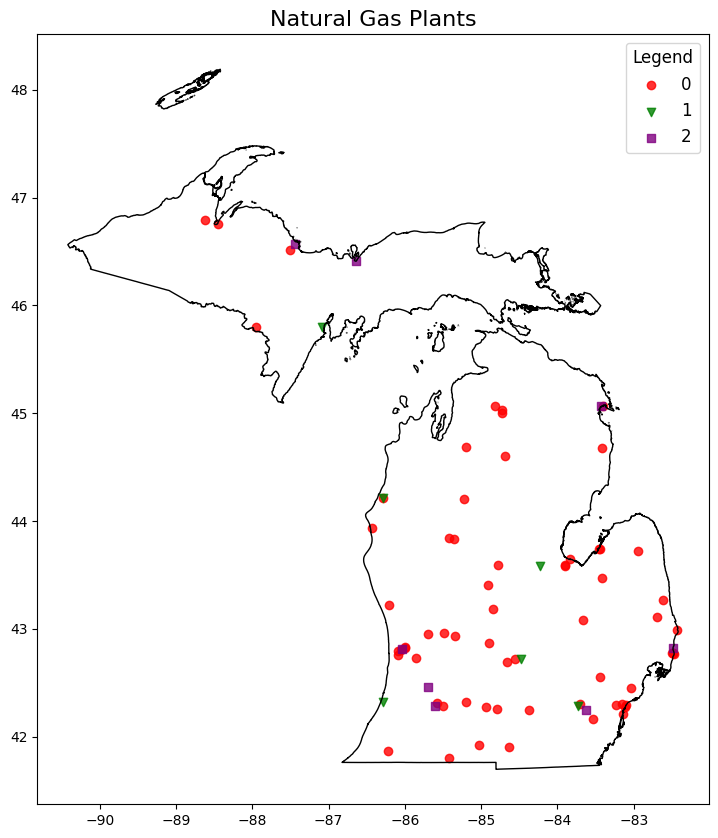

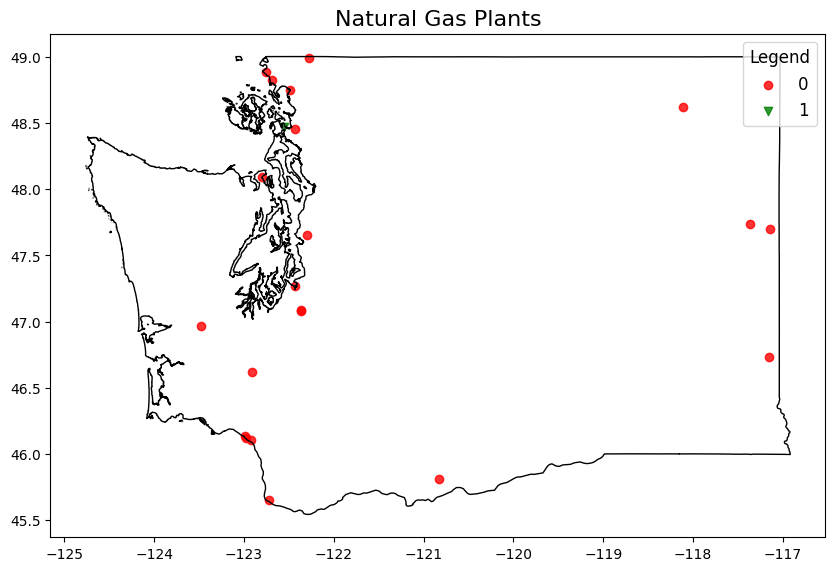

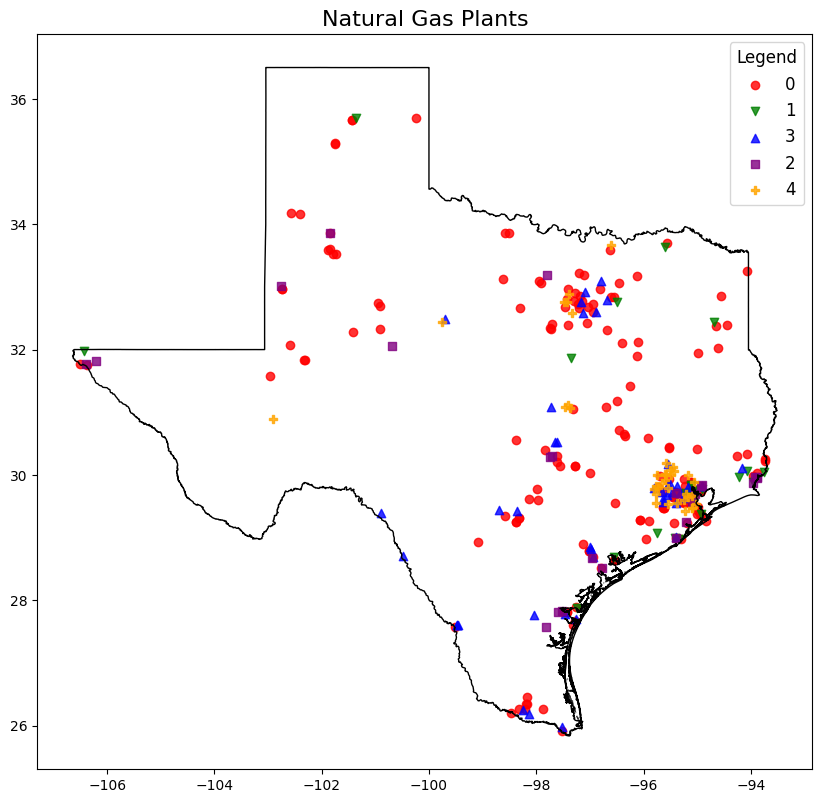

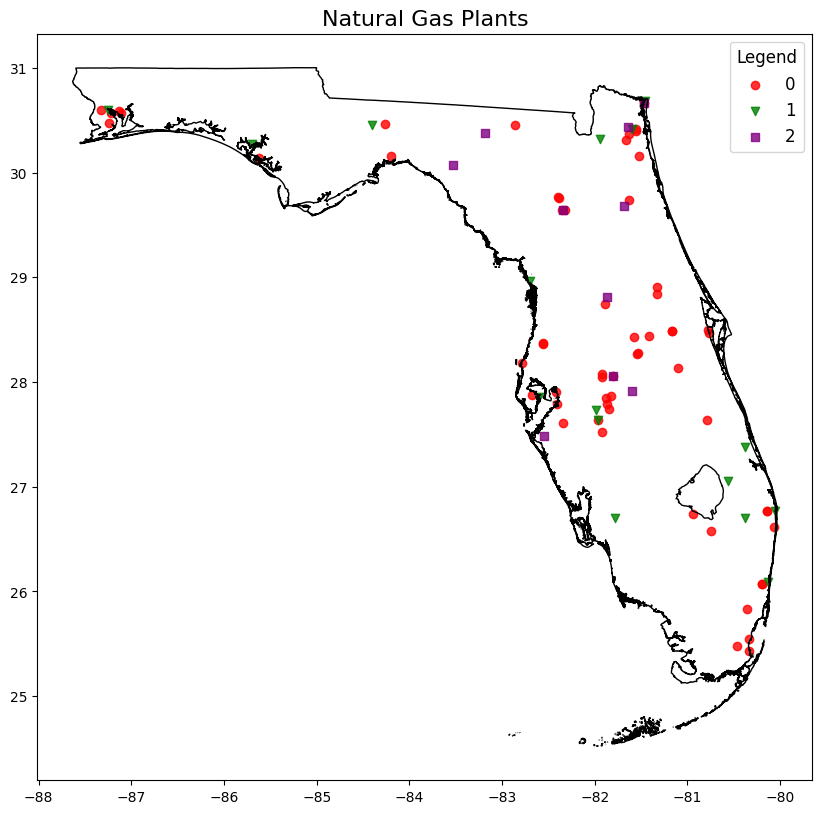

In [8]:
plot_plant_categories(norm_location)

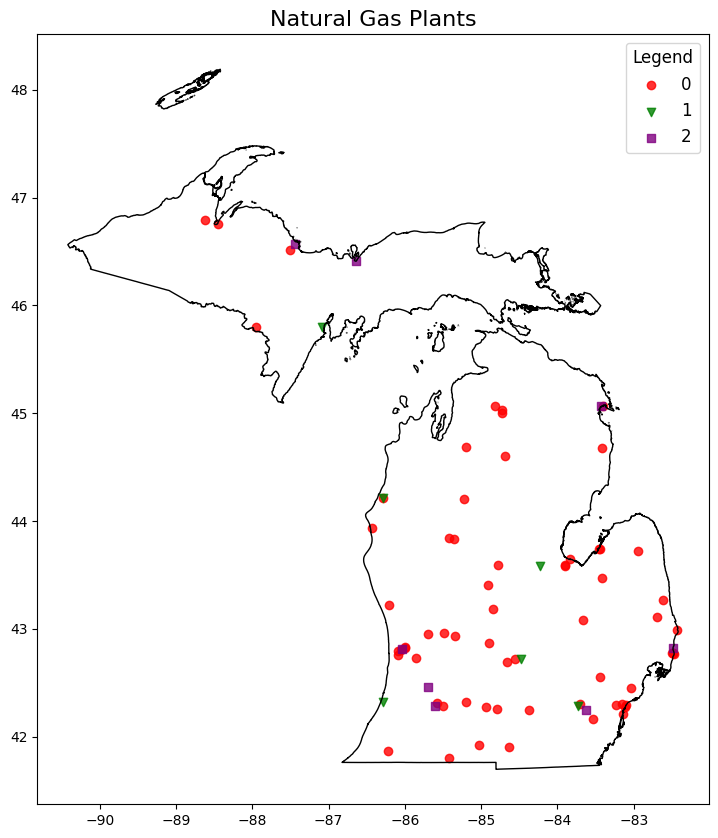

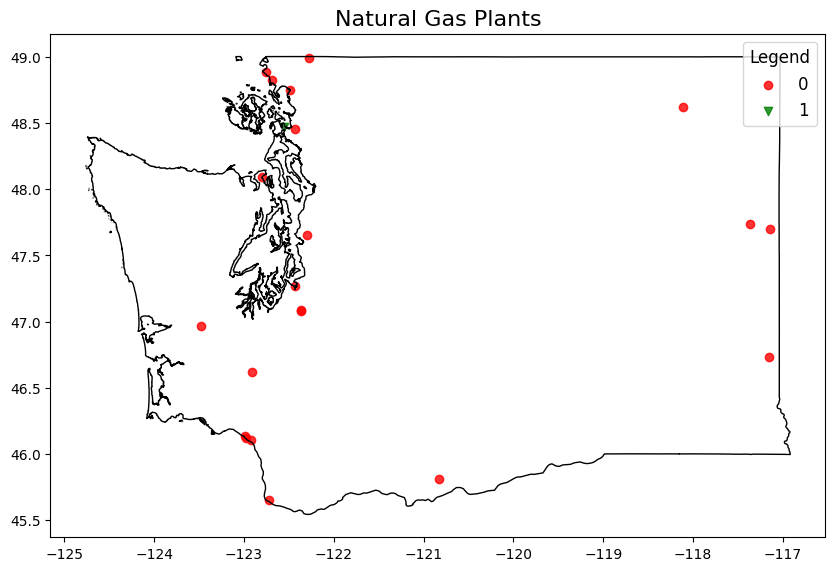

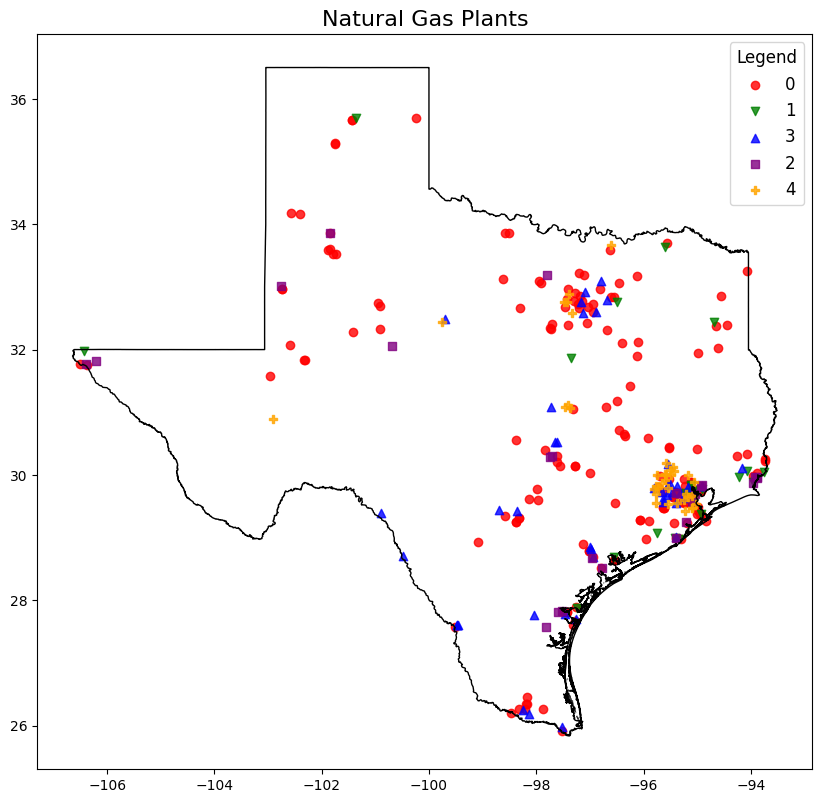

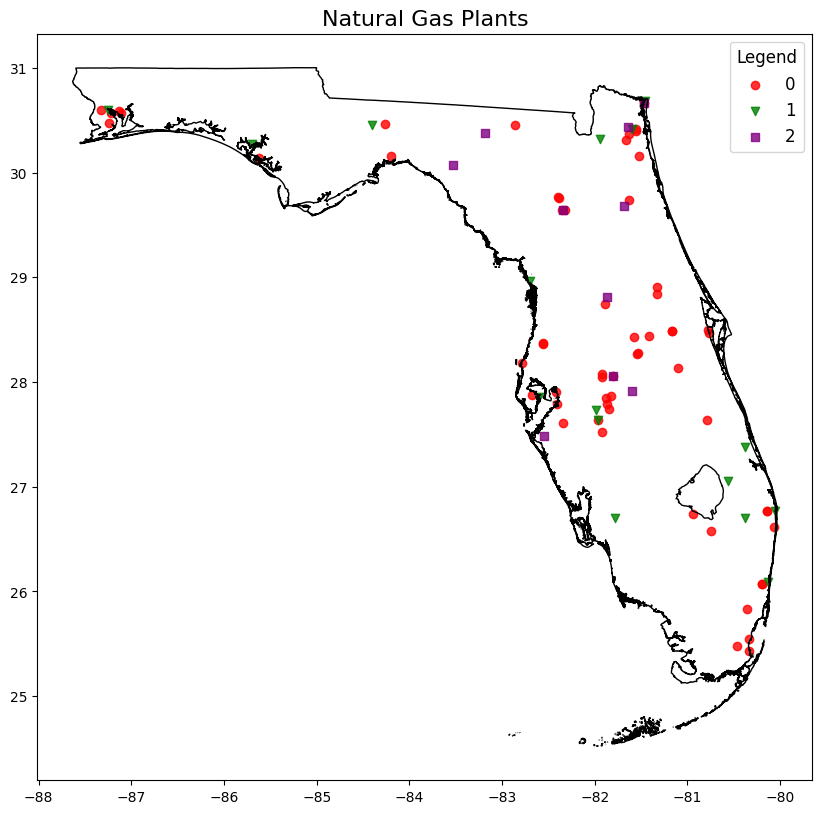

In [77]:
plot_plant_categories(norm_location)

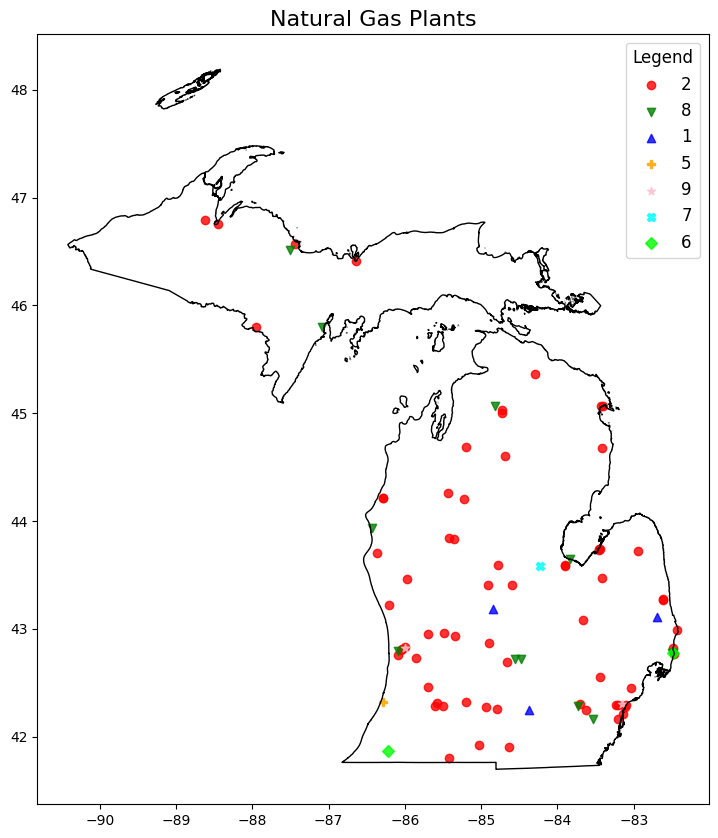

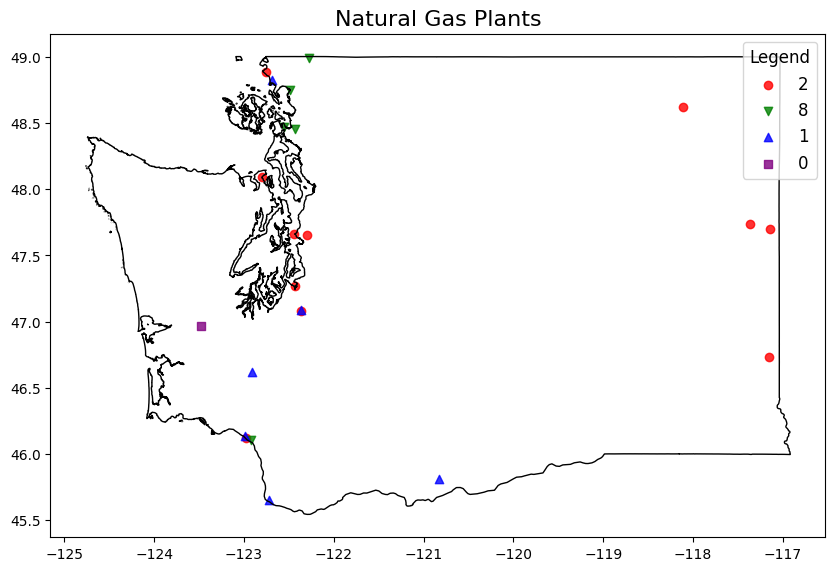

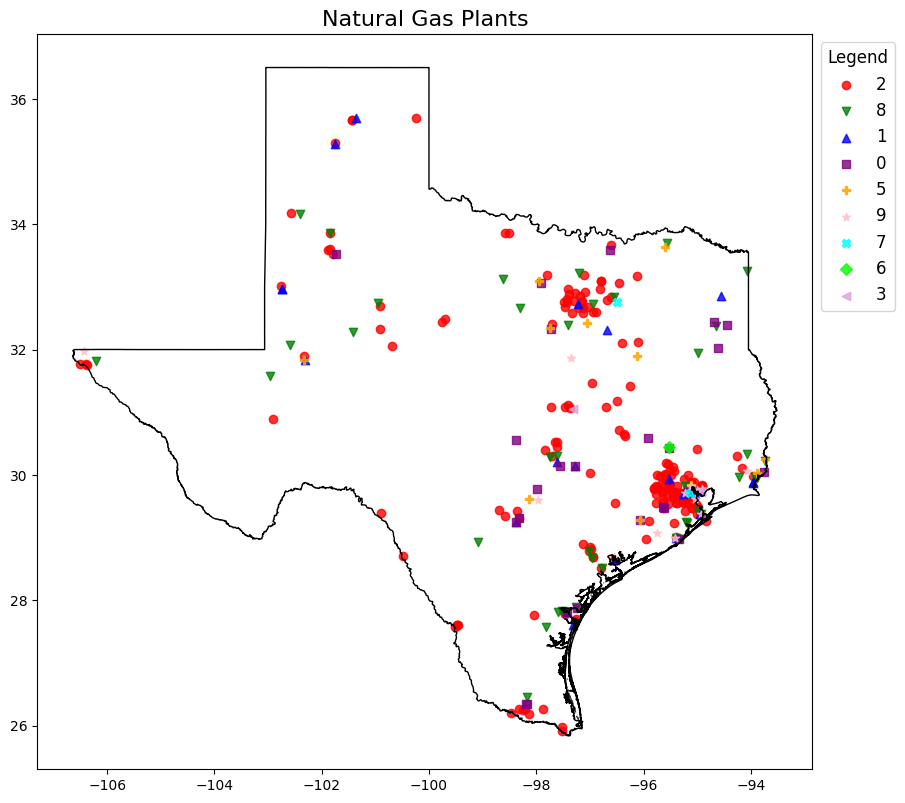

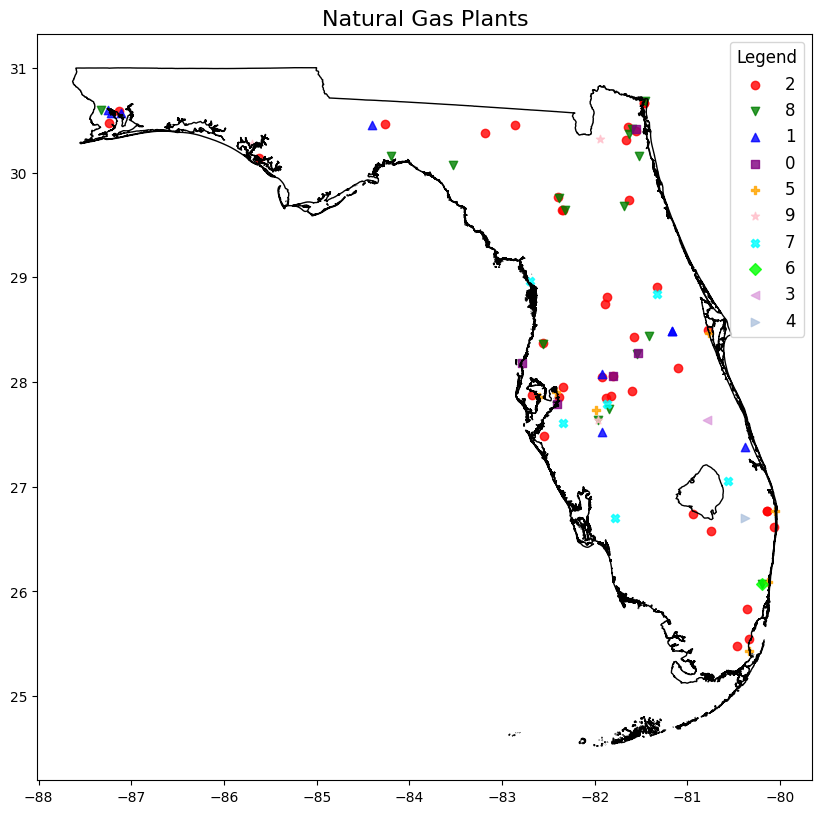

In [78]:
plot_plant_categories(raw_location)

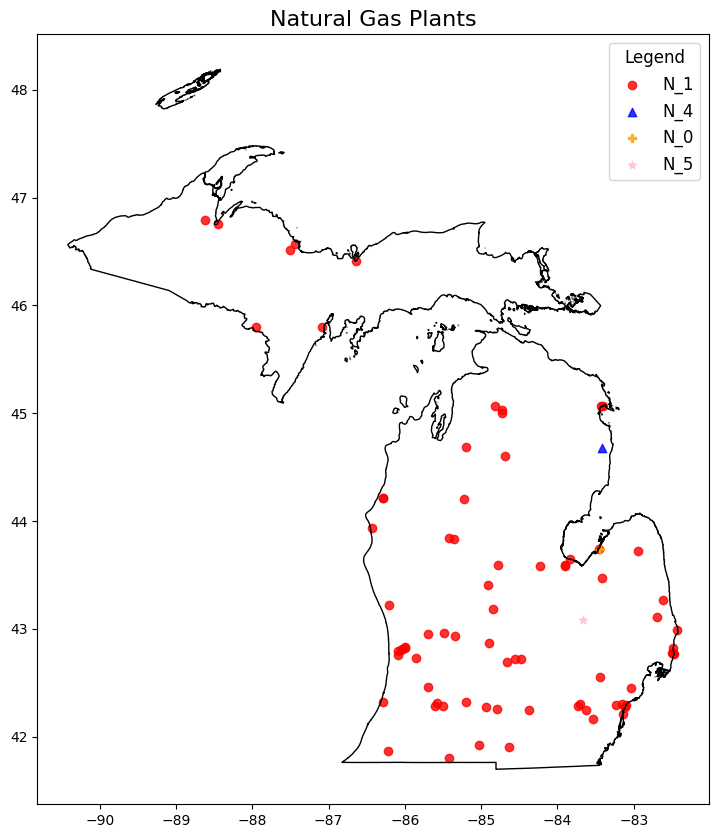

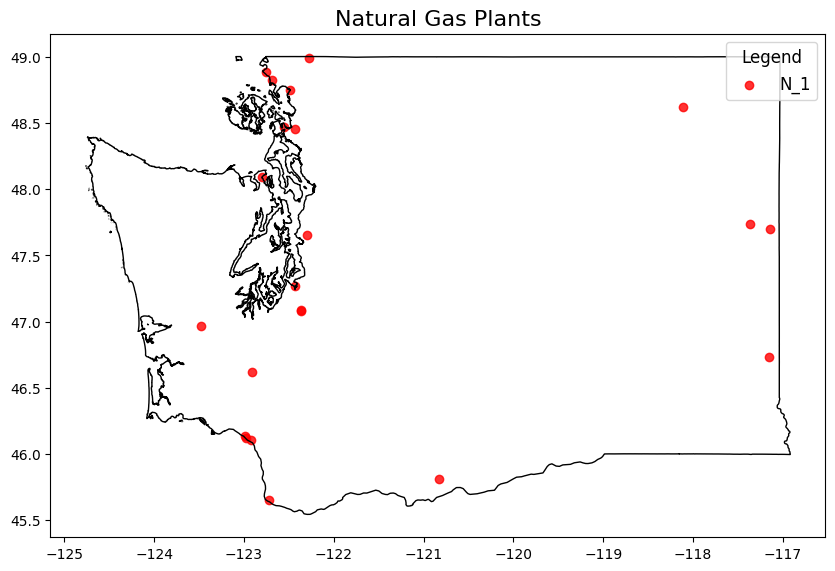

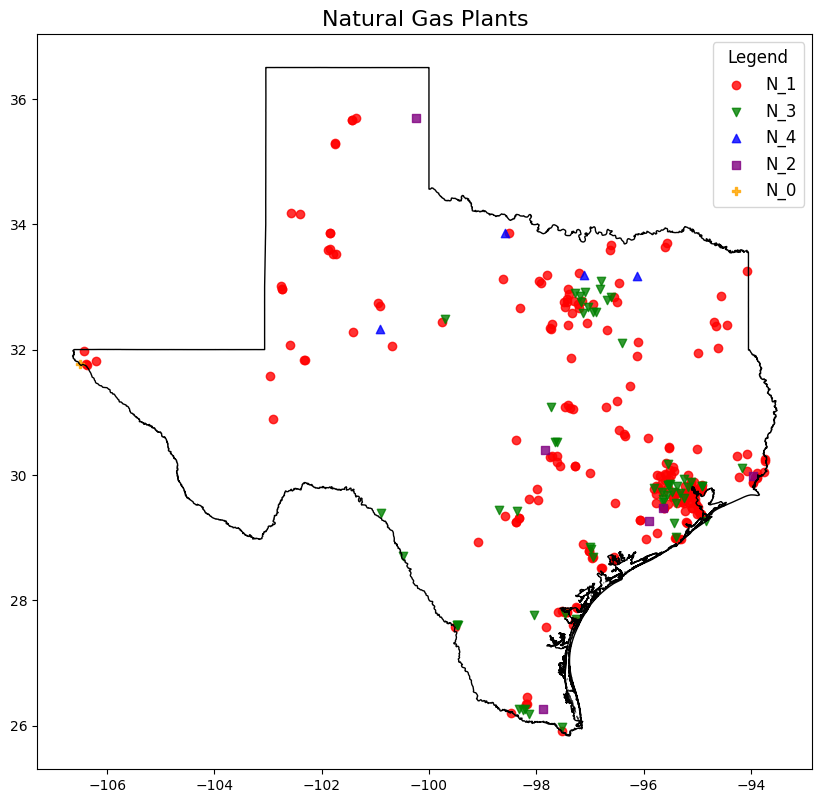

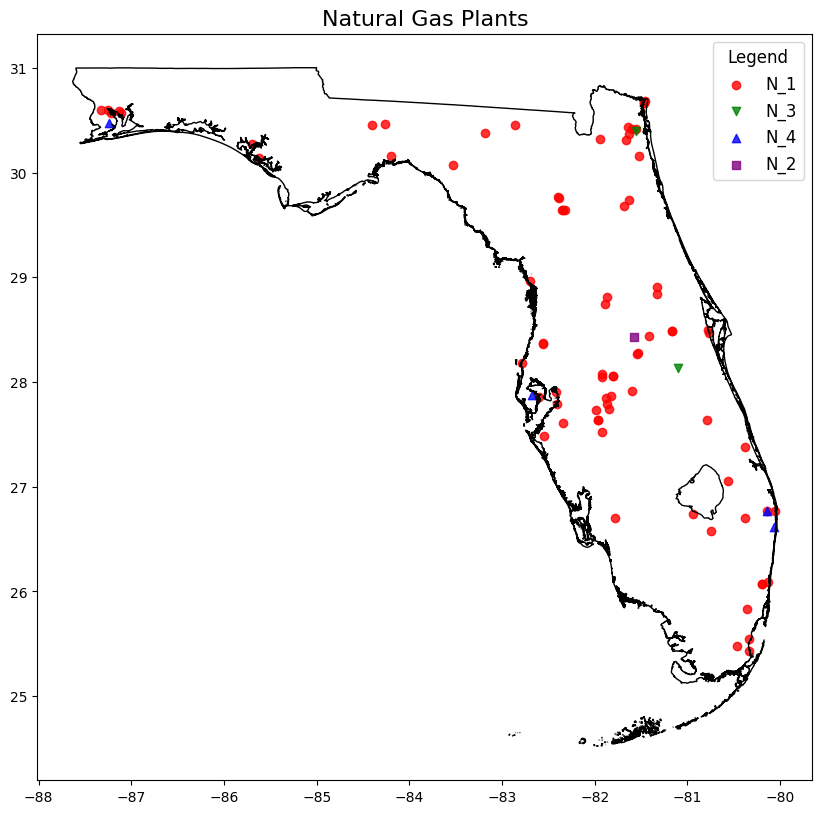

In [28]:
plot_plant_categories(norm_location)

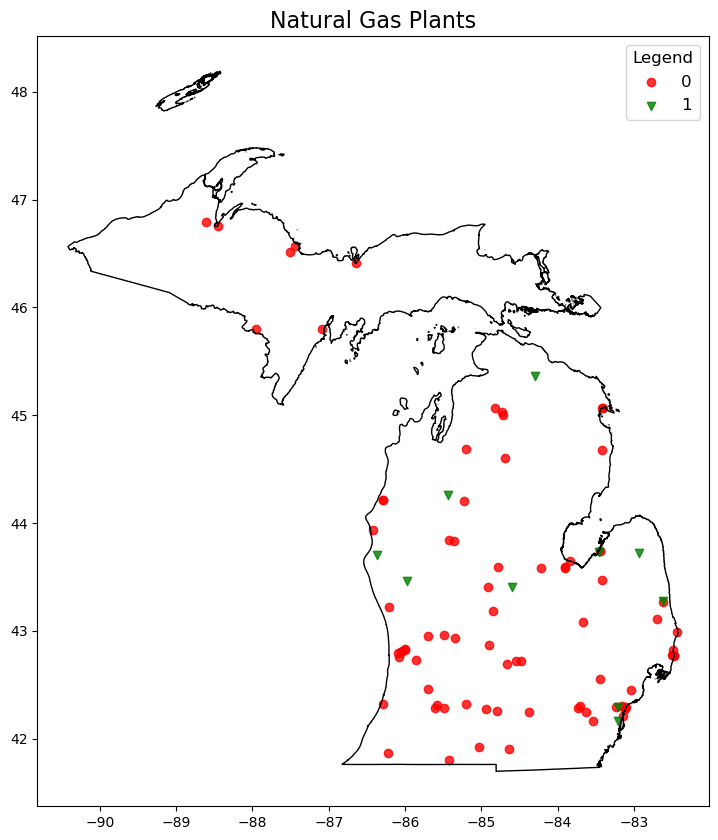

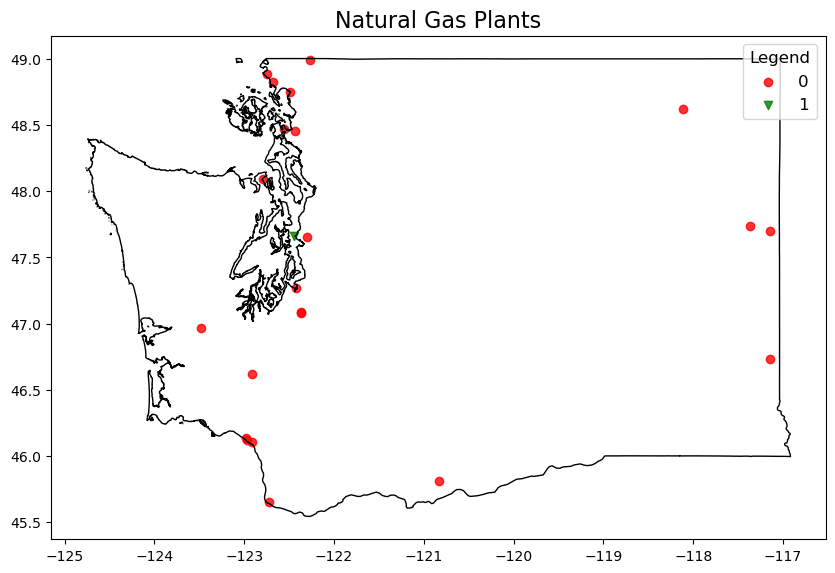

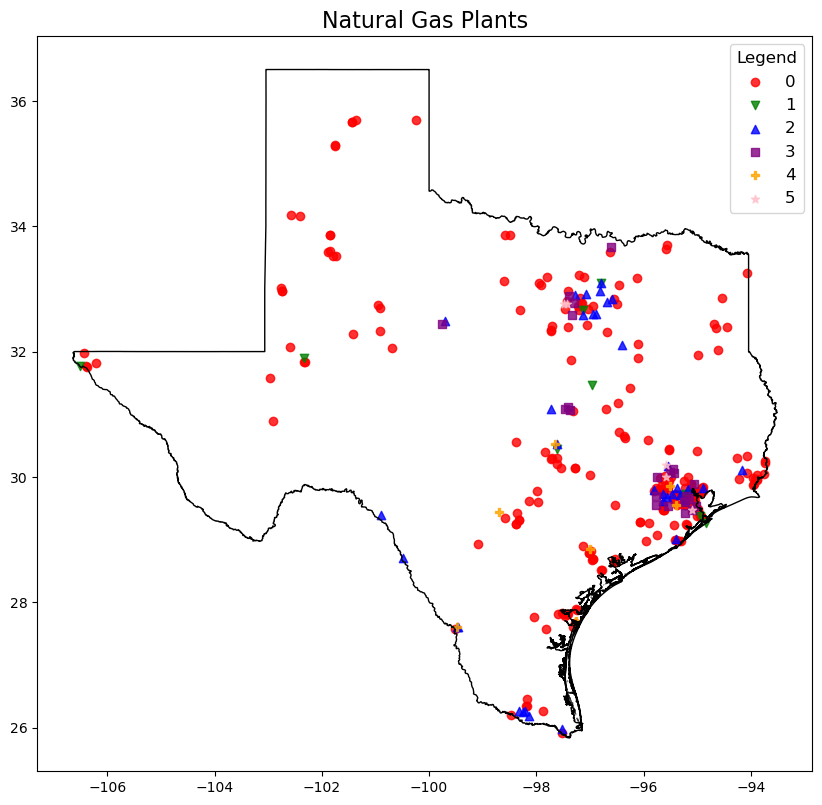

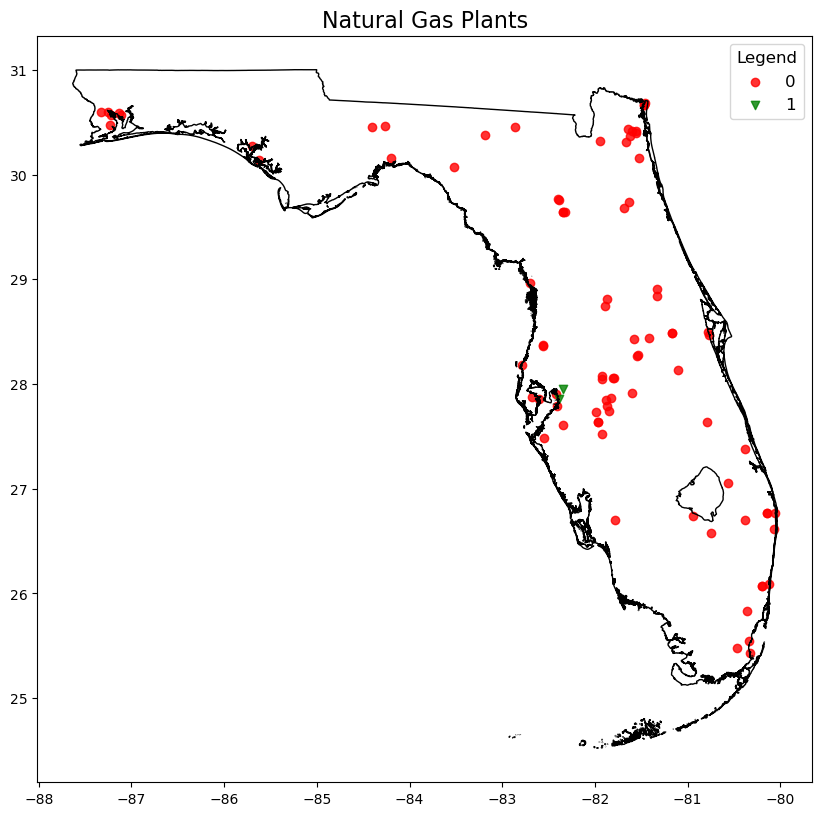

In [90]:
plot_plant_categories(raw_location)